In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf
import statsmodels.api as sm
from pylab import rcParams
import warnings


cf.go_offline()

### Setting visual parameters of plot

In [2]:
rcParams['figure.figsize'] = 20, 10
plt.style.use('fivethirtyeight')


### Importing dataset

In [3]:
chicago_cmr = pd.read_csv('chicago_clean.csv')

### Changing index to Datetime and resampling dataset to group crime counts by month

In [4]:
chicago_timeindex = chicago_cmr.set_index(pd.DatetimeIndex(chicago_cmr.Date))
daysample_crime = pd.DataFrame(chicago_timeindex.resample('M').size().reset_index())


### Plotting crime counts grouped by month to check seasonality and trend

In [23]:
daysample_crime.iplot(kind='line', x='Date', xTitle='Year/Month',
          color='green', yTitle='Total Number of Crimes', title='Number of Crimes by Month/Year')

In [5]:
daysample_crime = chicago_cmr.set_index(pd.DatetimeIndex(chicago_cmr['Date']))
daysample_crime = daysample_crime.resample('M').size()

### Decomposing our monthly sample to check the trend, seasonality and noise separately

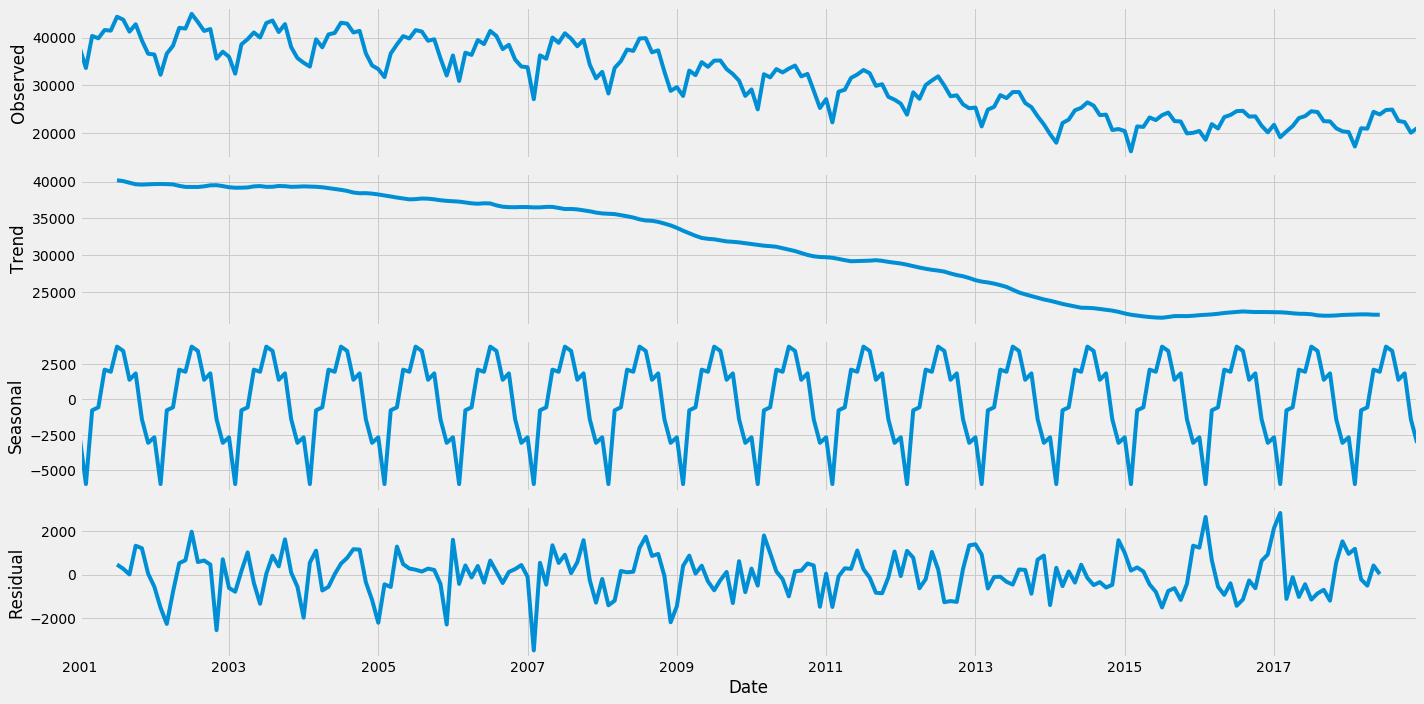

In [75]:
decomposition = sm.tsa.seasonal_decompose(daysample_crime, model='additive')
fig = decomposition.plot()
plt.show()

## Parameter Selection Arima

### Hyperparameter selection (grid search)

#### Resource: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [11]:
mod = sm.tsa.statespace.SARIMAX(daysample_crime,
                                order=(2, 0, 1),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5514      0.112     13.911      0.000       1.333       1.770
ar.L2         -0.5527      0.110     -5.005      0.000      -0.769      -0.336
ma.L1         -1.0611      0.046    -22.973      0.000      -1.152      -0.971
ar.S.L12       0.0923      0.147      0.629      0.529      -0.195       0.380
ar.S.L24       0.0305      0.038      0.799      0.424      -0.044       0.105
ma.S.L12      -0.6565      0.096     -6.860      0.000      -0.844      -0.469
sigma2       1.62e+06   3.84e-08   4.22e+13      0.000    1.62e+06    1.62e+06


/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



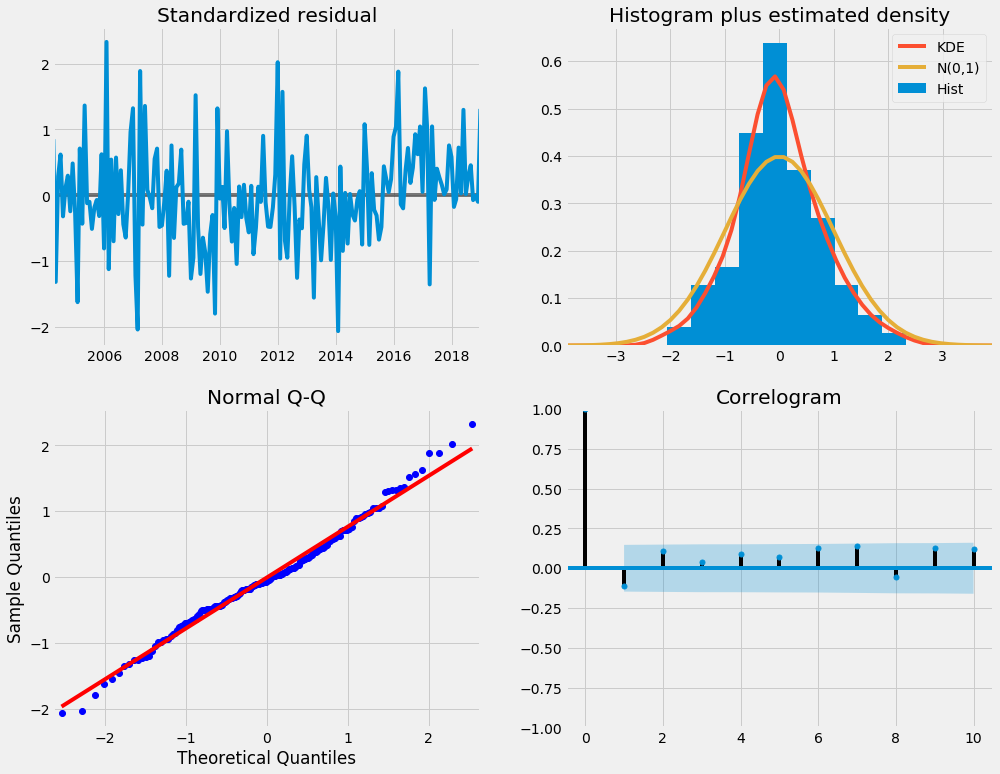

In [12]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [13]:
pred = results.get_prediction(start=pd.to_datetime('2002-01-31'), dynamic=False)
pred_ci = pred.conf_int()

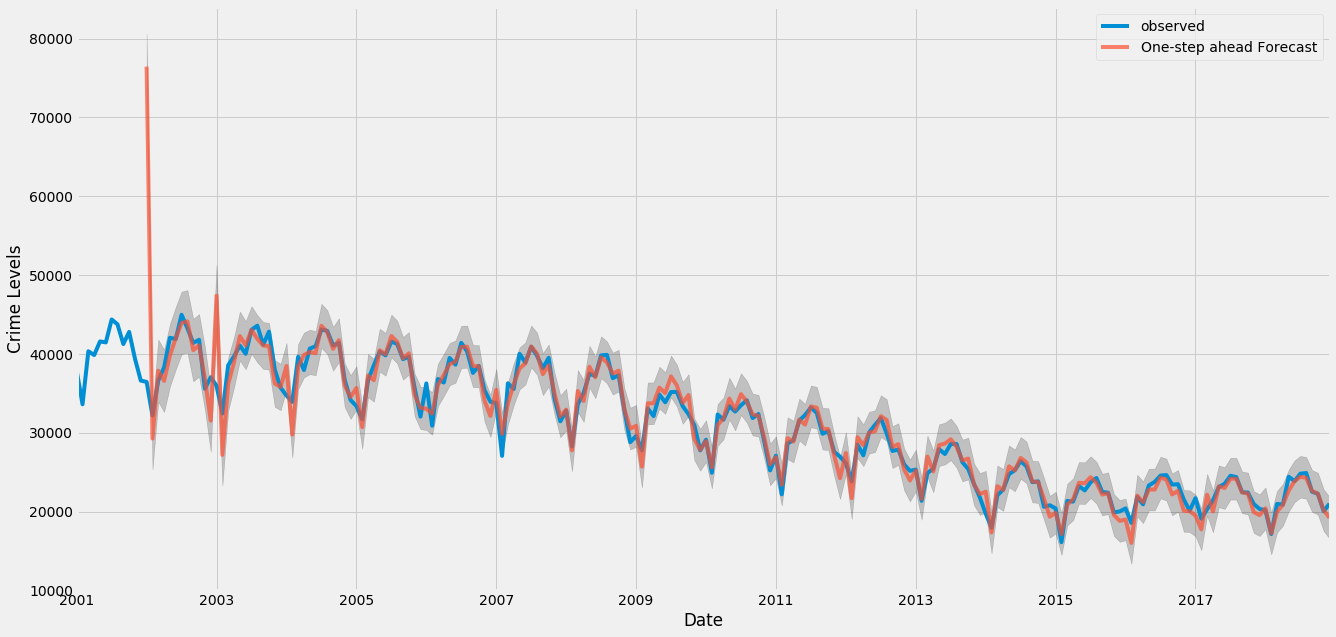

In [14]:
ax = daysample_crime['2001':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Crime Levels')
plt.legend()

plt.show()

In [23]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=70)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

### Plotting our prediction

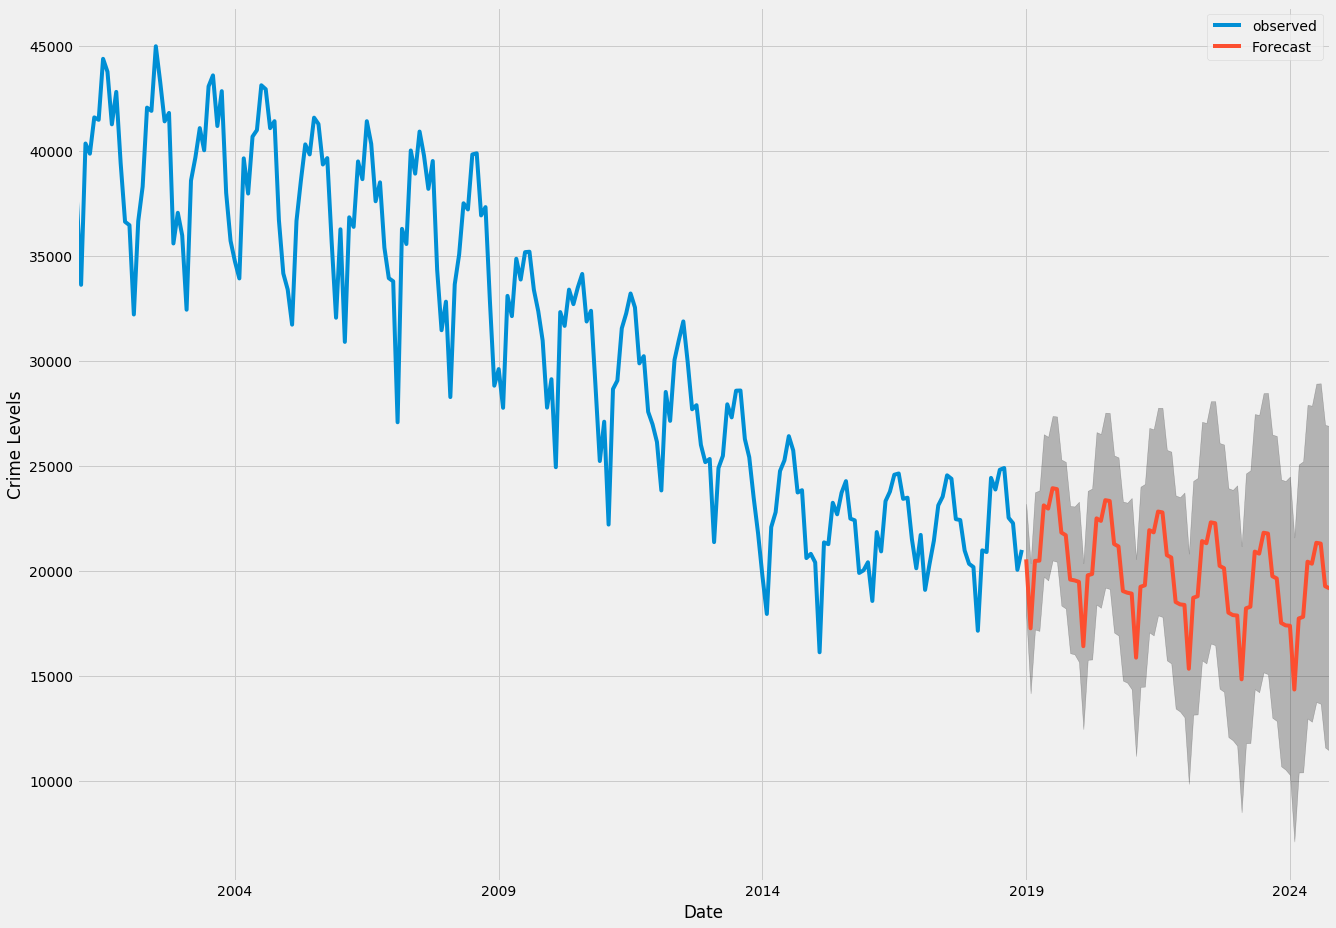

In [24]:
ax = daysample_crime.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Levels')

plt.legend()
plt.show()

### Resource : https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

In [10]:
# grid search sarima hyperparameters for monthly car sales dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models


# load dataset
#series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = daysample_crime
print(daysample_crime.shape)
# data split
n_test = 12
# model configs
cfg_list = sarima_configs(seasonal=[12])
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

(216,)
 > Model[[(0, 0, 0), (0, 0, 0, 12), 'n']] 22022.158
 > Model[[(0, 0, 0), (0, 1, 0, 12), 'n']] 927.942
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'n']] 1147.328
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'n']] 12143.031
 > Model[[(0, 0, 0), (1, 1, 0, 12), 'n']] 1067.694
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'n']] 1158.746
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'n']] 979.568
 > Model[[(0, 0, 0), (2, 0, 0, 12), 'n']] 1164.410
 > Model[[(0, 0, 0), (1, 1, 1, 12), 'n']] 1077.010
 > Model[[(0, 0, 0), (0, 0, 2, 12), 'n']] 7972.769
 > Model[[(0, 0, 0), (0, 0, 0, 12), 'c']] 9743.904
 > Model[[(0, 0, 0), (2, 1, 0, 12), 'n']] 1156.595
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'c']] 5158.275
 > Model[[(0, 0, 0), (1, 0, 2, 12), 'n']] 1213.678
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'c']] 1380.792
 > Model[[(0, 0, 0), (2, 0, 1, 12), 'n']] 1268.716
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'c']] 2181.822
 > Model[[(0, 0, 0), (0, 1, 2, 12), 'n']] 1122.291
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'c']] 5060.855
 > Model[[(0, 0, 0), (2,

 > Model[[(0, 0, 2), (2, 1, 0, 12), 'n']] 1101.598
 > Model[[(0, 0, 2), (1, 0, 0, 12), 'c']] 4082.146
 > Model[[(0, 0, 2), (0, 1, 1, 12), 'c']] 1148.434
 > Model[[(0, 0, 2), (2, 0, 2, 12), 'n']] 1160.910
 > Model[[(0, 0, 2), (1, 1, 0, 12), 'c']] 1090.427
 > Model[[(0, 0, 2), (1, 0, 1, 12), 'c']] 2653.367
 > Model[[(0, 0, 2), (0, 0, 2, 12), 'c']] 2385.261
 > Model[[(0, 0, 2), (1, 1, 2, 12), 'n']] 1144.478
 > Model[[(0, 0, 2), (2, 1, 1, 12), 'n']] 1101.464
 > Model[[(0, 0, 2), (0, 1, 2, 12), 'c']] 1136.306
 > Model[[(0, 0, 2), (1, 1, 1, 12), 'c']] 1082.354
 > Model[[(0, 0, 2), (2, 0, 0, 12), 'c']] 4170.437
 > Model[[(0, 0, 2), (2, 0, 1, 12), 'c']] 2629.799
 > Model[[(0, 0, 2), (0, 0, 0, 12), 't']] 7157.252
 > Model[[(0, 0, 2), (1, 0, 2, 12), 'c']] 2252.218
 > Model[[(0, 0, 2), (2, 1, 2, 12), 'n']] 1049.562
 > Model[[(0, 0, 2), (0, 0, 1, 12), 't']] 8393.350
 > Model[[(0, 0, 2), (0, 1, 0, 12), 't']] 1425.707
 > Model[[(0, 0, 2), (2, 1, 0, 12), 'c']] 1134.315
 > Model[[(0, 0, 2), (1, 1, 2, 

 > Model[[(0, 1, 1), (0, 1, 1, 12), 't']] 673.885
 > Model[[(0, 1, 1), (0, 0, 2, 12), 't']] 1571.530
 > Model[[(0, 1, 1), (2, 0, 2, 12), 'c']] 955.418
 > Model[[(0, 1, 1), (1, 0, 0, 12), 't']] 1205.974
 > Model[[(0, 1, 1), (1, 0, 1, 12), 't']] 773.390
 > Model[[(0, 1, 1), (1, 1, 0, 12), 't']] 935.635
 > Model[[(0, 1, 1), (2, 1, 0, 12), 'c']] 741.346
 > Model[[(0, 1, 1), (1, 1, 1, 12), 't']] 669.925
 > Model[[(0, 1, 1), (0, 1, 2, 12), 't']] 654.945
 > Model[[(0, 1, 1), (1, 1, 2, 12), 'c']] 660.571
 > Model[[(0, 1, 1), (2, 1, 1, 12), 'c']] 655.216
 > Model[[(0, 1, 1), (1, 0, 2, 12), 't']] 754.827
 > Model[[(0, 1, 1), (2, 0, 0, 12), 't']] 1018.099
 > Model[[(0, 1, 1), (0, 0, 0, 12), 'ct']] 1995.865
 > Model[[(0, 1, 1), (0, 0, 1, 12), 'ct']] 1582.095
 > Model[[(0, 1, 1), (2, 0, 1, 12), 't']] 734.846
 > Model[[(0, 1, 1), (2, 1, 2, 12), 'c']] 639.806
 > Model[[(0, 1, 1), (0, 1, 0, 12), 'ct']] 1017.786
 > Model[[(0, 1, 1), (2, 1, 0, 12), 't']] 740.653
 > Model[[(0, 1, 1), (2, 0, 2, 12), 't']]

 > Model[[(1, 0, 0), (2, 0, 2, 12), 't']] 1032.426
 > Model[[(1, 0, 0), (0, 1, 1, 12), 'ct']] 1049.133
 > Model[[(1, 0, 0), (1, 0, 0, 12), 'ct']] 2093.434
 > Model[[(1, 0, 0), (1, 1, 2, 12), 't']] 1127.269
 > Model[[(1, 0, 0), (0, 0, 2, 12), 'ct']] 1591.369
 > Model[[(1, 0, 0), (1, 0, 1, 12), 'ct']] 1973.238
 > Model[[(1, 0, 0), (2, 1, 0, 12), 't']] 1120.994
 > Model[[(1, 0, 0), (1, 1, 0, 12), 'ct']] 1077.986
 > Model[[(1, 0, 0), (0, 1, 2, 12), 'ct']] 975.320
 > Model[[(1, 0, 0), (1, 1, 1, 12), 'ct']] 903.013
 > Model[[(1, 0, 0), (2, 1, 1, 12), 't']] 1190.314
 > Model[[(1, 0, 0), (1, 0, 2, 12), 'ct']] 1711.043
 > Model[[(1, 0, 0), (2, 0, 0, 12), 'ct']] 2124.607
 > Model[[(1, 0, 1), (0, 0, 0, 12), 'n']] 1970.432
 > Model[[(1, 0, 1), (0, 0, 1, 12), 'n']] 1565.635
 > Model[[(1, 0, 0), (2, 1, 2, 12), 't']] 1055.359
 > Model[[(1, 0, 1), (0, 1, 0, 12), 'n']] 1042.067
 > Model[[(1, 0, 0), (2, 0, 1, 12), 'ct']] 1729.837
 > Model[[(1, 0, 0), (2, 0, 2, 12), 'ct']] 1653.214
 > Model[[(1, 0, 1), (

 > Model[[(1, 1, 0), (0, 1, 1, 12), 'n']] 738.132
 > Model[[(1, 1, 0), (0, 0, 2, 12), 'n']] 1540.075
 > Model[[(1, 1, 0), (1, 0, 0, 12), 'n']] 1176.432
 > Model[[(1, 1, 0), (1, 0, 1, 12), 'n']] 874.098
 > Model[[(1, 0, 2), (2, 0, 2, 12), 'ct']] 1356.004
 > Model[[(1, 1, 0), (1, 1, 0, 12), 'n']] 978.614
 > Model[[(1, 1, 0), (1, 0, 2, 12), 'n']] 750.720
 > Model[[(1, 1, 0), (1, 1, 1, 12), 'n']] 739.757
 > Model[[(1, 1, 0), (2, 0, 0, 12), 'n']] 1048.043
 > Model[[(1, 1, 0), (0, 1, 2, 12), 'n']] 716.210
 > Model[[(1, 1, 0), (2, 0, 1, 12), 'n']] 779.018
 > Model[[(1, 1, 0), (2, 1, 0, 12), 'n']] 731.579
 > Model[[(1, 1, 0), (2, 0, 2, 12), 'n']] 832.926
 > Model[[(1, 1, 0), (0, 0, 0, 12), 'c']] 1935.015
 > Model[[(1, 1, 0), (1, 1, 2, 12), 'n']] 716.153
 > Model[[(1, 1, 0), (0, 0, 1, 12), 'c']] 1529.264
 > Model[[(1, 1, 0), (0, 1, 0, 12), 'c']] 1106.754
 > Model[[(1, 0, 2), (2, 1, 0, 12), 'ct']] 801.083
 > Model[[(1, 0, 2), (1, 1, 2, 12), 'ct']] 721.037
 > Model[[(1, 0, 2), (2, 1, 1, 12), 'ct'

 > Model[[(1, 1, 1), (2, 1, 2, 12), 'ct']] 679.686
 > Model[[(1, 1, 2), (0, 0, 2, 12), 'c']] 1557.168
 > Model[[(1, 1, 2), (1, 0, 0, 12), 'c']] 1171.614
 > Model[[(1, 1, 2), (0, 1, 1, 12), 'c']] 656.329
 > Model[[(1, 1, 2), (1, 0, 1, 12), 'c']] 916.030
 > Model[[(1, 1, 2), (1, 1, 2, 12), 'n']] 678.340
 > Model[[(1, 1, 2), (2, 1, 1, 12), 'n']] 661.753
 > Model[[(1, 1, 2), (2, 1, 0, 12), 'n']] 778.684
 > Model[[(1, 1, 2), (1, 1, 0, 12), 'c']] 905.785
 > Model[[(1, 1, 2), (1, 1, 1, 12), 'c']] 700.836
 > Model[[(1, 1, 2), (1, 0, 2, 12), 'c']] 905.958
 > Model[[(1, 1, 2), (2, 1, 2, 12), 'n']] 682.074
 > Model[[(1, 1, 2), (2, 0, 0, 12), 'c']] 986.962
 > Model[[(1, 1, 2), (0, 0, 0, 12), 't']] 1800.021
 > Model[[(1, 1, 2), (2, 0, 1, 12), 'c']] 839.280
 > Model[[(1, 1, 2), (0, 1, 2, 12), 'c']] 692.329
 > Model[[(1, 1, 2), (0, 1, 0, 12), 't']] 1017.661
 > Model[[(1, 1, 2), (0, 0, 1, 12), 't']] 1493.019
 > Model[[(1, 1, 2), (2, 0, 2, 12), 'c']] 759.799
 > Model[[(1, 1, 2), (1, 0, 0, 12), 't']] 10

 > Model[[(2, 0, 1), (2, 0, 2, 12), 'c']] 1023.111
 > Model[[(2, 0, 1), (0, 0, 2, 12), 't']] 1614.356
 > Model[[(2, 0, 1), (0, 1, 1, 12), 't']] 790.663
 > Model[[(2, 0, 1), (2, 1, 0, 12), 'c']] 917.594
 > Model[[(2, 0, 1), (1, 0, 1, 12), 't']] 1100.318
 > Model[[(2, 0, 1), (1, 1, 2, 12), 'c']] 981.889
 > Model[[(2, 0, 1), (1, 0, 0, 12), 't']] 1398.302
 > Model[[(2, 0, 1), (1, 1, 0, 12), 't']] 999.959
 > Model[[(2, 0, 1), (1, 0, 2, 12), 't']] 910.387
 > Model[[(2, 0, 1), (1, 1, 1, 12), 't']] 776.505
 > Model[[(2, 0, 1), (0, 1, 2, 12), 't']] 663.357
 > Model[[(2, 0, 1), (2, 1, 1, 12), 'c']] 868.094
 > Model[[(2, 0, 1), (2, 0, 0, 12), 't']] 1029.255
 > Model[[(2, 0, 1), (2, 1, 2, 12), 'c']] 1011.080
 > Model[[(2, 0, 1), (0, 0, 0, 12), 'ct']] 2239.821
 > Model[[(2, 0, 1), (0, 0, 1, 12), 'ct']] 1626.541
 > Model[[(2, 0, 1), (2, 0, 1, 12), 't']] 895.214
 > Model[[(2, 0, 1), (0, 1, 0, 12), 'ct']] 1142.261
 > Model[[(2, 0, 1), (2, 0, 2, 12), 't']] 897.115
 > Model[[(2, 0, 1), (0, 0, 2, 12), 'c

 > Model[[(2, 1, 0), (0, 0, 2, 12), 'ct']] 1560.754
 > Model[[(2, 1, 0), (0, 1, 1, 12), 'ct']] 726.861
 > Model[[(2, 1, 0), (2, 0, 2, 12), 't']] 805.980
 > Model[[(2, 1, 0), (2, 1, 0, 12), 't']] 734.095
 > Model[[(2, 1, 0), (1, 1, 2, 12), 't']] 704.831
 > Model[[(2, 1, 0), (1, 0, 0, 12), 'ct']] 1174.882
 > Model[[(2, 1, 0), (1, 0, 1, 12), 'ct']] 897.751
 > Model[[(2, 1, 0), (1, 1, 0, 12), 'ct']] 986.763
 > Model[[(2, 1, 0), (2, 1, 1, 12), 't']] 644.066
 > Model[[(2, 1, 0), (1, 1, 1, 12), 'ct']] 729.740
 > Model[[(2, 1, 0), (1, 0, 2, 12), 'ct']] 747.579
 > Model[[(2, 1, 0), (0, 1, 2, 12), 'ct']] 690.821
 > Model[[(2, 1, 0), (2, 0, 0, 12), 'ct']] 1074.915
 > Model[[(2, 1, 1), (0, 0, 0, 12), 'n']] 1794.295
 > Model[[(2, 1, 0), (2, 1, 2, 12), 't']] 633.070
 > Model[[(2, 1, 1), (0, 0, 1, 12), 'n']] 1574.862
 > Model[[(2, 1, 1), (0, 1, 0, 12), 'n']] 1033.414
 > Model[[(2, 1, 0), (2, 0, 1, 12), 'ct']] 770.406
 > Model[[(2, 1, 1), (0, 1, 1, 12), 'n']] 685.448
 > Model[[(2, 1, 1), (0, 0, 2, 12)

 > Model[[(2, 1, 2), (2, 1, 1, 12), 'ct']] 631.514
 > Model[[(2, 1, 2), (2, 1, 2, 12), 'ct']] 664.646
done
[(2, 0, 1), (2, 1, 1, 12), 'ct'] 565.49730746393
[(1, 1, 2), (2, 1, 1, 12), 't'] 586.5568277796875
[(2, 1, 2), (2, 1, 2, 12), 't'] 598.714817239928


### Best hyperparameters and root mean square error

In [1]:
#[(2, 0, 1), (2, 1, 1, 12), 'ct'] 565.49730746393

SyntaxError: invalid syntax (<ipython-input-1-b1493dcb63ec>, line 1)